## install

In [ ]:
%%capture
import os

!python -m pip install --upgrade pip
!pip install typing_extensions==4.12.2
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    !pip install --no-deps unsloth vllm
# Install latest Hugging Face for Gemma-3!
!pip install --no-deps git+https://github.com/huggingface/transformers@v4.49.0-Gemma-3

In [ ]:
# #@title Colab Extra Install { display-mode: "form" }
# %%capture
# import os
# if "COLAB_" not in "".join(os.environ.keys()):
#     !pip install unsloth vllm
# else:
#     !pip install --no-deps unsloth vllm
#     # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
#     # Skip restarting message in Colab
#     import sys, re, requests; modules = list(sys.modules.keys())
#     for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None
#     !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft "trl==0.15.2" triton cut_cross_entropy unsloth_zoo
#     !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer

#     # vLLM requirements - vLLM breaks Colab due to reinstalling numpy
#     f = requests.get("https://raw.githubusercontent.com/vllm-project/vllm/refs/heads/main/requirements/common.txt").content
#     with open("vllm_requirements.txt", "wb") as file:
#         file.write(re.sub(rb"(transformers|numpy|xformers)[^\n]{1,}\n", b"", f))
#     !pip install -r vllm_requirements.txt


## [Load Model](https://huggingface.co/unsloth)

In [ ]:
from unsloth import FastModel
import torch

fourbit_models = [
    # 4bit dynamic quants for superior accuracy and low memory use
    "unsloth/gemma-3-1b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-4b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-12b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-27b-it-unsloth-bnb-4bit",

    # Other popular models!
    "unsloth/Llama-3.1-8B",
    "unsloth/Llama-3.2-3B",
    "unsloth/Llama-3.3-70B",
    "unsloth/mistral-7b-instruct-v0.3",
    "unsloth/Phi-4",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/gemma-3-4b-it",
    max_seq_length = 8184, # Choose any for long context!
    load_in_4bit = True,  # 4 bit quantization to reduce memory
    load_in_8bit = False, # [NEW!] A bit more accurate, uses 2x memory
    full_finetuning = False, # [NEW!] We have full finetuning now!
    # token = "hf_...", # use one if using gated models
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 04-13 00:11:49 [__init__.py:239] Automatically detected platform cuda.
Unsloth: We'll be using `/tmp/unsloth_compiled_cache` for temporary Unsloth patches.
Standard import failed for UnslothBCOTrainer: No module named 'UnslothBCOTrainer'. Using tempfile instead!
==((====))==  Unsloth 2025.3.19: Fast Gemma3 patching. Transformers: 4.50.0.dev0. vLLM: 0.8.3.
   \\   /|    NVIDIA RTX A5000. Num GPUs = 1. Max memory: 23.573 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.56G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

## PEFT : LoRA

In [ ]:
model = FastModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # Turn off for just text!
    finetune_language_layers   = True,  # Should leave on!
    finetune_attention_modules = True,  # Attention good for GRPO
    finetune_mlp_modules       = True,  # SHould leave on always!
    r = 64,           # 0보다 큰 어떤 숫자도 선택 가능! 8, 16, 32, 64, 128이 권장됩니다.
    lora_alpha = 64,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",   # 바이어스를 지원합니다.
    random_state = 3407
)

Unsloth: Making `model.base_model.model.language_model.model` require gradients


## datasets

In [ ]:
from datasets import load_dataset

# dataset 폴더 안에 있는 모든 CSV 파일을 불러옵니다.
csv_files = [os.path.join("dataset", file) for file in os.listdir("dataset") if file.endswith(".csv")]

# 데이터셋 로드
dataset = load_dataset("csv", data_files=csv_files, split="train")

# 데이터셋 확인
print(dataset)

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['user_input', 'reference_contexts', 'reference'],
    num_rows: 1629
})


In [ ]:
# EOS_TOKEN은 문장의 끝을 나타내는 토큰입니다. 이 토큰을 추가해야 합니다.
EOS_TOKEN = tokenizer.eos_token

# AlpacaPrompt를 사용하여 지시사항을 포맷팅하는 함수입니다.
alpaca_prompt = """
You are tasked with creating a recipe and detailed cooking instructions based on the ingredients provided.
The recipe should focus on a specific Korean dish that can be made using the given ingredients, with a brief description of the dish and the necessary steps for cooking.
For each step, make sure to clearly state the ingredients and tools used, as well as the exact cooking times.
The instructions should be as detailed as possible, specifying the cooking time for each step and the tools and methods required to prepare the dish.
For example, specify the exact cooking time for each step and provide clear instructions on the tools and techniques needed so the user can easily follow the process.

Focus on using traditional Korean ingredients and cooking tools, such as kimchi, soy sauce, sesame oil, and stovetop cooking. Include the necessary Korean cooking techniques, such as stir-frying, simmering, or steaming.

For instance:
- Ingredients: Kimchi, Pork, Green onions
- Tools: Frying pan, Ladle
- Cooking instructions:
   1. Cut the pork into bite-sized pieces.
   2. Heat the frying pan and add oil. Cook the pork on medium heat for about 5 minutes.
   3. Add the kimchi and green onions to the pan and stir-fry. Add a little soy sauce to adjust the taste, and cook for another 3 minutes.
   4. Once everything is well-cooked, remove from heat and serve.

Make sure to provide clear cooking times, tools, and detailed steps that align with traditional Korean cooking practices. This will ensure that the recipe is easy to follow and the user can successfully recreate the dish.

### User_Input:
{}

### Response:
{}

"""


# 주어진 예시들을 포맷팅하는 함수입니다.
def formatting_prompts_func(examples):
    questions = examples["user_input"]  # 질문을 가져옵니다.
    outputs = examples["reference"]    # 답변을 가져옵니다.
    texts = []  # 포맷팅된 텍스트를 저장할 리스트입니다.
    for question, output in zip(questions, outputs):
        # EOS_TOKEN을 추가해야 합니다. 그렇지 않으면 생성이 무한히 진행될 수 있습니다.
        text = alpaca_prompt.format(question, output) + EOS_TOKEN
        texts.append(text)
    return {
        "text": texts,  # 포맷팅된 텍스트를 반환합니다.
    }

# 데이터셋에 formatting_prompts_func 함수를 적용합니다. 배치 처리를 활성화합니다.
dataset = dataset.map(
    formatting_prompts_func,
    batched=True,
)

Map:   0%|          | 0/1629 [00:00<?, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['user_input', 'reference_contexts', 'reference', 'text'],
    num_rows: 1629
})

In [ ]:
# 데이터셋에서 'text' 컬럼을 리스트로 변환
texts = dataset['text']

# 각 텍스트의 길이를 계산
text_lengths = [len(text) for text in texts]

# 최대 길이 계산
max_length = max(text_lengths)
print("최대 텍스트 길이:", max_length)

최대 텍스트 길이: 2084


In [ ]:
from trl import SFTTrainer, SFTConfig

tokenizer.padding_side = "right"  # 토크나이저의 패딩을 오른쪽으로 설정합니다.

# SFTTrainer를 사용하여 모델 학습 설정
trainer = SFTTrainer(
    model=model,  # 학습할 모델
    tokenizer=tokenizer,  # 토크나이저
    train_dataset=dataset,  # 학습 데이터셋
    eval_dataset=dataset,   # 테디노트에서 추가된 eval dataset
    dataset_text_field="text",  # 데이터셋에서 텍스트 필드의 이름
    dataset_num_proc=2,  # 데이터 처리에 사용할 프로세스 수
    packing=False,  # 짧은 시퀀스에 대한 학습 속도를 5배 빠르게 할 수 있음
    args=SFTConfig(
        max_seq_length=1500,  # 최대 시퀀스 길이
        per_device_train_batch_size=4,  # 각 디바이스당 훈련 배치 크기
        gradient_accumulation_steps=8,  # 그래디언트 누적 단계
        warmup_steps=500,  # 웜업 스텝 수
        num_train_epochs=5,  # 훈련 에폭 수
        max_steps=2000,  # 최대 스텝 수 # 공식문서에는 60
        logging_steps=1,  # logging 스텝 수
        learning_rate=2e-5,  # 학습률
        fp16=not torch.cuda.is_bf16_supported(),  # fp16 사용 여부, bf16이 지원되지 않는 경우에만 사용
        bf16=torch.cuda.is_bf16_supported(),  # bf16 사용 여부, bf16이 지원되는 경우에만 사용
        optim="adamw_hf",  # 최적화 알고리즘
        weight_decay=0.01,  # 가중치 감소
        lr_scheduler_type="cosine",  # 학습률 스케줄러 유형 # 공식은 linear
        seed=123,  # 랜덤 시드 # 공식은 3407
        output_dir="outputs",  # 출력 디렉토리
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/1629 [00:00<?, ? examples/s]

## Train

In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA RTX A5000. Max memory = 23.573 GB.
4.732 GB of memory reserved.


In [ ]:
# @title Training model
trainer_stats = trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,629 | Num Epochs = 40 | Total steps = 2,000
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 8 x 1) = 32
 "-____-"     Trainable parameters = 119,209,984/4,000,000,000 (2.98% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.434800
2,2.408100
3,2.439700
4,2.407200
5,2.431700
6,2.414300
7,2.411400
8,2.440400
9,2.414000
10,2.431300


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

16807.6233 seconds used for training.
280.13 minutes used for training.
Peak reserved memory = 6.936 GB.
Peak reserved memory for training = 2.204 GB.
Peak reserved memory % of max memory = 29.423 %.
Peak reserved memory for training % of max memory = 9.35 %.


## Inference

In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template="gemma-3",
)

# 질문들
questions = [
    "양파, 마늘, 그리고 계란을 사용해서 20분 이내에 후라이팬만 이용해 만들 수 있는 요리를 추천해주세요.",
    "닭고기와 감자, 그리고 30분의 시간이 있을 때, 오븐을 이용해서 만들 수 있는 요리 레시피를 알려주세요.",
    "고기와 채소를 사용하여 15분 안에 전자레인지로 만들 수 있는 간단한 요리를 추천해주세요.",
    "소고기, 감자, 그리고 40분의 시간이 있을 때, 후라이팬만 사용해서 만들 수 있는 요리를 추천해주세요."
]

# 답변들
answers = []

# 모델 추론을 위해 각 질문을 처리
for question in questions:
    # 추론 중 메시지 출력
    print("=" * 100)
    print("모델이 답변을 생성 중입니다...")
    print("\n")

    messages = [{
        "role": "user",
        "content": [{"type": "text", "text": question}]
    }]

    # 템플릿 적용
    text = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,  # 모델 생성을 위한 프롬프트 추가
    )

    # 모델 추론
    output = model.generate(
        **tokenizer([text], return_tensors="pt").to("cuda"),
        max_new_tokens=1000,  # 출력 길이 증가
        temperature=1.0, top_p=0.95, top_k=64,
    )

    # 추론 완료 후 결과 출력
    # 텍스트 출력
    decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
    answers.append(decoded_output)
    print("Response:")
    print(decoded_output)  # 텐서가 아닌 텍스트 출력
    print("=" * 100)



모델이 답변을 생성 중입니다...


Response:
user
양파, 마늘, 그리고 계란을 사용해서 20분 이내에 후라이팬만 이용해 만들 수 있는 요리를 추천해주세요.
model
네, 양파, 마늘, 계란을 후라이팬으로 20분 이내에 만들 수 있는 요리들은 정말 많습니다. 간단하고 빠르게 만들 수 있는 몇 가지 요리를 추천해 드릴게요.

**1. 계란 양파 마늘 볶음**

*   **조리 과정:**
    1.  양파를 얇게 썰고, 마늘도 다져줍니다. (청양고추를 추가해도 맛있습니다.)
    2.  후라이팬에 기름을 살짝 두르고, 양파를 볶습니다. 양파가 투명해질 때까지 볶아주세요.
    3.  그 다음 다진 마늘과 청양고추를 넣고 조금 더 볶습니다.
    4.  계란을 풀어 후라이팬에 넣고, 노른자에 스크램블이 잘 섞이도록 저어줍니다. 소금으로 간을 맞추고, 참기름에 찍어 마무리합니다.
*   **조리 시간:** 약 10분
*   **특징:** 정말 간단하게 만들 수 있으며, 매일 올짝물과 함께 먹으면 풍미가 더해져 맛이 깊어집니다.

**2. 마늘 마요 계란 덮밥**

*   **조리 과정:**
    1.  양파는 얇게 썰어 물에 살짝 데친 후, 마늘가루와 섞어줍니다. (양파를 생 양파로 사용할 경우, 흐르는 물에 깨끗이 씻고 썰어줍니다.)
    2.  계란을 스크램블 만들듯이 계란과 물, 소금을 잘 저어 후라이팬에 넣고, 노른자가 살짝 덜 익은 상태에서 마늘 양념을 덮 위에 뿌려줍니다.
    3.  밥을 넣고 잘 비벼주면 맛있는 마늘 마요 계란 덮밥이 완성됩니다.
*   **조리 시간:** 약 10분
*   **특징:** 남녀노소 모두가 좋아하는 맛으로, 아이들 간식으로도 좋습니다.

**3. 양파 계란 큐볶음**

*   **조리 과정:**
    1.  양파를 좋아하는 크기로 썰고, 마늘도 다져줍니다.
    2.  후라이팬에 기름을 두르고, 양파를 볶습니다. 양파가 익을 때까지 조리하며, 중간에 강불로 조절하여 아삭한 식감을 유지합니다.


## save model

### VLLM을 위한 float4 저장

In [ ]:
base_model = "gemma3" # 병합을 수행할 베이스 모델
# huggingface_token = ""  # HuggingFace 토큰
# huggingface_repo = "Llama-3-Open-Ko-8B-Instruct-teddynote"  # 모델을 업로드할 repository
save_method = (
    "merged_4bit"  # "merged_4bit", "merged_4bit_forced", "merged_16bit", "lora"
)

In [ ]:
model.save_pretrained_merged(
    base_model,
    tokenizer,
    save_method=save_method,  # 저장 방식을 16비트 병합으로 설정
)

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  50%|█████     | 1/2 [00:35<00:35, 35.42s/it]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 2/2 [00:57<00:00, 28.81s/it]


### GGUF 변환

In [ ]:
# Quantization 방식 설정
quantization_method = "q8_0"  # "f16" "q8_0" "q4_k_m" "q5_k_m"

In [ ]:
model.save_pretrained_gguf(
    base_model, # 사전학습 모델이 저장될 폴더명
    quantization_type=quantization_method,
)

Unsloth: Updating system package directories
Unsloth: Install GGUF and other packages
Unsloth GGUF:hf-to-gguf:Loading model: gemma3
Unsloth GGUF:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
Unsloth GGUF:hf-to-gguf:Exporting model...
Unsloth GGUF:hf-to-gguf:gguf: loading model weight map from 'model.safetensors.index.json'
Unsloth GGUF:hf-to-gguf:gguf: loading model part 'model-00001-of-00002.safetensors'
Unsloth GGUF:hf-to-gguf:token_embd.weight,                 torch.bfloat16 --> Q8_0, shape = {2560, 262208}
Unsloth GGUF:hf-to-gguf:gguf: loading model part 'model-00002-of-00002.safetensors'
Unsloth GGUF:hf-to-gguf:output_norm.weight,                torch.bfloat16 --> F32, shape = {2560}
Unsloth GGUF:hf-to-gguf:Set meta model
Unsloth GGUF:hf-to-gguf:Set model parameters
Unsloth GGUF:hf-to-gguf:Set model tokenizer
Unsloth GGUF:gguf.vocab:Setting special token type bos to 2
Unsloth GGUF:gguf.vocab:Setting special token type eos to 106
Unsloth GGUF:gguf.vocab:Setting sp

Unsloth: GGUF conversion:   0%|          | 0/100 [00:00<?, ?it/s]

Unsloth GGUF:hf-to-gguf:Model successfully exported to ./
Unsloth: Converted to gemma3.Q8_0.gguf with size = 4.1G
Unsloth: Successfully saved GGUF to:
gemma3.Q8_0.gguf


['gemma3.Q8_0.gguf']

In [ ]:
import os

os.environ["HF_TOKEN"] = ""

In [ ]:
model.push_to_hub_gguf(
    base_model,
    quantization_type = "Q8_0", # Only Q8_0, BF16, F16 supported
    repo_id = "seungdang/gemma3-miniproj3-finetune-model2-gguf",
    # token = "hf_"
)

Unsloth GGUF:hf-to-gguf:Loading model: gemma3
Unsloth GGUF:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
Unsloth GGUF:hf-to-gguf:Exporting model...
Unsloth GGUF:hf-to-gguf:gguf: loading model weight map from 'model.safetensors.index.json'
Unsloth GGUF:hf-to-gguf:gguf: loading model part 'model-00001-of-00002.safetensors'
Unsloth GGUF:hf-to-gguf:token_embd.weight,                 torch.bfloat16 --> Q8_0, shape = {2560, 262208}
Unsloth GGUF:hf-to-gguf:gguf: loading model part 'model-00002-of-00002.safetensors'
Unsloth GGUF:hf-to-gguf:output_norm.weight,                torch.bfloat16 --> F32, shape = {2560}
Unsloth GGUF:hf-to-gguf:Set meta model
Unsloth GGUF:hf-to-gguf:Set model parameters
Unsloth GGUF:hf-to-gguf:Set model tokenizer
Unsloth GGUF:gguf.vocab:Setting special token type bos to 2
Unsloth GGUF:gguf.vocab:Setting special token type eos to 106
Unsloth GGUF:gguf.vocab:Setting special token type unk to 3
Unsloth GGUF:gguf.vocab:Setting special token type pad to 0


Unsloth: GGUF conversion:   0%|          | 0/100 [00:00<?, ?it/s]

Unsloth GGUF:hf-to-gguf:Model successfully exported to ./
Unsloth: Converted to gemma3.Q8_0.gguf with size = 4.1G
Unsloth: Successfully saved GGUF to:
gemma3.Q8_0.gguf


No files have been modified since last commit. Skipping to prevent empty commit.


['gemma3.Q8_0.gguf']

In [ ]:
#@title 수동 업로드
from huggingface_hub import HfApi

api = HfApi()
api.upload_file(
    path_or_fileobj="./gemma3.Q8_0.gguf",
    path_in_repo="gemma3-miniproj3-finetune-model2.Q8_0.gguf",
    repo_id="seungdang/gemma3-miniproj3-finetune-model2-gguf",
    repo_type="model",
    # token = "hf_"
)

  0%|          | 0/1 [00:00<?, ?it/s]

(…)mma3-miniproj3-finetune-model2.Q8_0.gguf:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/seungdang/gemma3-miniproj3-finetune-model2-gguf/commit/b3cedfeed308463c1936ca5722d3e386ed60b859', commit_message='Upload gemma3-miniproj3-finetune-model2.Q8_0.gguf with huggingface_hub', commit_description='', oid='b3cedfeed308463c1936ca5722d3e386ed60b859', pr_url=None, repo_url=RepoUrl('https://huggingface.co/seungdang/gemma3-miniproj3-finetune-model2-gguf', endpoint='https://huggingface.co', repo_type='model', repo_id='seungdang/gemma3-miniproj3-finetune-model2-gguf'), pr_revision=None, pr_num=None)

### [hugging face 확인](https://huggingface.co/good593/gemma3-finetune-gguf)

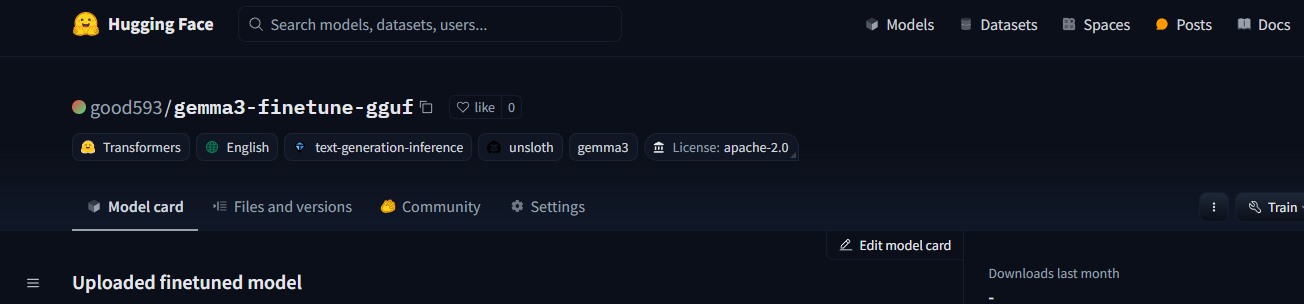

## GPT를 사용하여 질문에 대한 답을 평가

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = ''

In [ ]:
from openai import OpenAI

# GPT-4o-mini 모델 평가 함수
def evaluate_with_gpt4o(question, answer):
    # OpenAI GPT-4o-mini API 호출
    client = OpenAI()
    response = client.chat.completions.create(
        model="gpt-4o-mini",  # GPT-4o-mini 모델
        messages=[
            {"role": "system", "content": "당신은 한국 요리 전문가입니다. 전통적인 요리 방법, 재료, 기술에 대해 매우 잘 알고 있으며, 제공된 레시피를 평가하는 것이 임무입니다. 레시피의 명확성, 정확성, 그리고 적절한 요리 용어 사용에 대해 평가하세요. 요리 지침이 상세하고 정확하게 작성되어 있는지, 재료와 도구 사용이 적절한지, 조리 시간이 정확한지 평가해주세요. 또한, 언어가 올바르고 쉽게 이해될 수 있는지 평가하세요."},
            {"role": "user", "content": f"다음 레시피를 전문 한국 요리 전문가로서 평가해주세요:\n\n질문: {question}\n\n답변: {answer}\n\n레시피가 명확한 지침을 포함하고, 적절한 도구와 재료를 사용했는지, 정확한 조리 시간을 포함했는지, 언어가 정확하고 따라하기 쉬운지 평가해주세요."}
        ],
        max_tokens=1000,  # 최대 출력 길이
        temperature=0.7  # 적당한 창의성을 설정
    )

    # 응답에서 평가 결과 가져오기
    evaluation = response.choices[0].message.content
    return evaluation


# 각 질문에 대해 답변을 평가
# decoded_output : 이전 셀에서 모델이 생성한 결과
for question, answer in zip(questions, answers):
    evaluation = evaluate_with_gpt4o(question, answer)
    print(f"Question: {question}")
    print(f"Answer: {answer}\n")
    print(f"Evaluation: {evaluation}")
    print("=" * 100)


Question: 양파, 마늘, 그리고 계란을 사용해서 20분 이내에 후라이팬만 이용해 만들 수 있는 요리를 추천해주세요.
Answer: user
양파, 마늘, 그리고 계란을 사용해서 20분 이내에 후라이팬만 이용해 만들 수 있는 요리를 추천해주세요.
model
네, 양파, 마늘, 계란을 후라이팬으로 20분 이내에 만들 수 있는 요리들은 정말 많습니다. 간단하고 빠르게 만들 수 있는 몇 가지 요리를 추천해 드릴게요.

**1. 계란 양파 마늘 볶음**

*   **조리 과정:**
    1.  양파를 얇게 썰고, 마늘도 다져줍니다. (청양고추를 추가해도 맛있습니다.)
    2.  후라이팬에 기름을 살짝 두르고, 양파를 볶습니다. 양파가 투명해질 때까지 볶아주세요.
    3.  그 다음 다진 마늘과 청양고추를 넣고 조금 더 볶습니다.
    4.  계란을 풀어 후라이팬에 넣고, 노른자에 스크램블이 잘 섞이도록 저어줍니다. 소금으로 간을 맞추고, 참기름에 찍어 마무리합니다.
*   **조리 시간:** 약 10분
*   **특징:** 정말 간단하게 만들 수 있으며, 매일 올짝물과 함께 먹으면 풍미가 더해져 맛이 깊어집니다.

**2. 마늘 마요 계란 덮밥**

*   **조리 과정:**
    1.  양파는 얇게 썰어 물에 살짝 데친 후, 마늘가루와 섞어줍니다. (양파를 생 양파로 사용할 경우, 흐르는 물에 깨끗이 씻고 썰어줍니다.)
    2.  계란을 스크램블 만들듯이 계란과 물, 소금을 잘 저어 후라이팬에 넣고, 노른자가 살짝 덜 익은 상태에서 마늘 양념을 덮 위에 뿌려줍니다.
    3.  밥을 넣고 잘 비벼주면 맛있는 마늘 마요 계란 덮밥이 완성됩니다.
*   **조리 시간:** 약 10분
*   **특징:** 남녀노소 모두가 좋아하는 맛으로, 아이들 간식으로도 좋습니다.

**3. 양파 계란 큐볶음**

*   **조리 과정:**
    1.  양파를 좋아하는 크기로 썰고, 마늘도 다져줍니다.
    2.  후라이팬에 기름을 두르고, 양파를 볶습니다.